In [2]:
import jcopdl
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset
from torch import nn, optim
from jcopdl.callback import Callback, set_config
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset and Dataloader

In [3]:
bs = 64
crop_size = 229

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(229),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [9]:
label2cat = train_set.classes
label2cat

<function list.count(value, /)>

# Arsitektur and Config

In [6]:
from torchvision.models import resnet34

In [7]:
resnet = resnet34(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

In [16]:
class Customresnet(nn.Module):
    def __init__(self,output_size):
        super().__init__()
        self.resnet = resnet34(pretrained=True)
        self.freeze()
        self.num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(0.2),
    
            nn.Linear(256,10),
            nn.LogSoftmax()
            )
        
    def forward(self,x):
        return self.resnet(x)
    
    def freeze(self):
        for param in self.resnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.resnet.parameters():
            param.requires_grad = True

In [17]:
config = set_config({
    "output_size" : len(label2cat),
    "batch_size" : bs,
    "crop_size" : crop_size
})

# Phase 1 Adaption

In [18]:
model = Customresnet(config.output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=3, outdir="model")

In [19]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 1.8428 | Test_cost  = 1.2197 | Train_score = 0.3707 | Test_score = 0.6750 |




Epoch     2
Train_cost  = 1.2936 | Test_cost  = 0.9676 | Train_score = 0.5564 | Test_score = 0.6900 |




Epoch     3
Train_cost  = 1.1734 | Test_cost  = 0.8507 | Train_score = 0.5911 | Test_score = 0.7250 |




Epoch     4
Train_cost  = 1.0955 | Test_cost  = 0.7326 | Train_score = 0.6136 | Test_score = 0.7700 |




Epoch     5
Train_cost  = 1.0327 | Test_cost  = 0.6630 | Train_score = 0.6400 | Test_score = 0.7800 |




Epoch     6
Train_cost  = 1.0289 | Test_cost  = 0.6607 | Train_score = 0.6311 | Test_score = 0.7950 |




Epoch     7
Train_cost  = 0.9862 | Test_cost  = 0.6735 | Train_score = 0.6554 | Test_score = 0.7700 |
==> EarlyStop patience =  1 | Best test_score: 0.7950




Epoch     8
Train_cost  = 0.9484 | Test_cost  = 0.6435 | Train_score = 0.6729 | Test_score = 0.7950 |
==> EarlyStop patience =  2 | Best test_score: 0.7950




Epoch     9
Train_cost  = 0.9500 | Test_cost  = 0.6243 | Train_score = 0.6693 | Test_score = 0.8000 |




Epoch    10
Train_cost  = 0.9145 | Test_cost  = 0.6024 | Train_score = 0.6786 | Test_score = 0.7900 |
==> EarlyStop patience =  1 | Best test_score: 0.8000




Epoch    11
Train_cost  = 0.9363 | Test_cost  = 0.6627 | Train_score = 0.6664 | Test_score = 0.7650 |
==> EarlyStop patience =  2 | Best test_score: 0.8000




Epoch    12
Train_cost  = 0.8966 | Test_cost  = 0.6354 | Train_score = 0.6857 | Test_score = 0.8100 |




Epoch    13
Train_cost  = 0.8665 | Test_cost  = 0.5679 | Train_score = 0.6829 | Test_score = 0.8200 |




Epoch    14
Train_cost  = 0.9063 | Test_cost  = 0.6031 | Train_score = 0.6743 | Test_score = 0.8150 |
==> EarlyStop patience =  1 | Best test_score: 0.8200




Epoch    15
Train_cost  = 0.8898 | Test_cost  = 0.5609 | Train_score = 0.6779 | Test_score = 0.8300 |




Epoch    16
Train_cost  = 0.8780 | Test_cost  = 0.5338 | Train_score = 0.6850 | Test_score = 0.8300 |
==> EarlyStop patience =  1 | Best test_score: 0.8300




Epoch    17
Train_cost  = 0.8585 | Test_cost  = 0.5502 | Train_score = 0.6982 | Test_score = 0.8200 |
==> EarlyStop patience =  2 | Best test_score: 0.8300




Epoch    18
Train_cost  = 0.8438 | Test_cost  = 0.5592 | Train_score = 0.7061 | Test_score = 0.8200 |
==> EarlyStop patience =  3 | Best test_score: 0.8300
==> Execute Early Stopping at epoch: 18 | Best test_score: 0.8300
==> Best model is saved at model


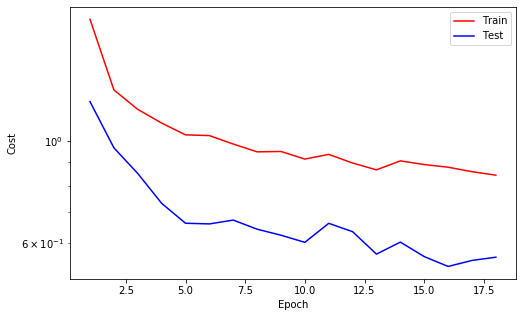

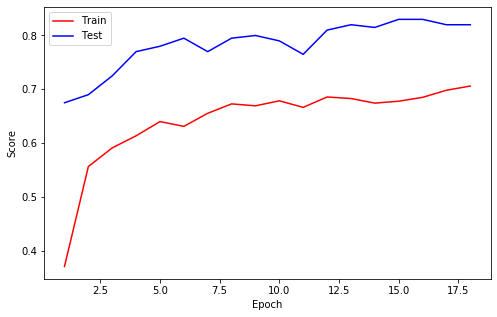

In [20]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Phase 2 : Fine Tuning

In [21]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience=3



Epoch    19
Train_cost  = 0.7780 | Test_cost  = 0.4268 | Train_score = 0.7221 | Test_score = 0.8600 |




Epoch    20
Train_cost  = 0.5979 | Test_cost  = 0.3675 | Train_score = 0.7875 | Test_score = 0.8850 |


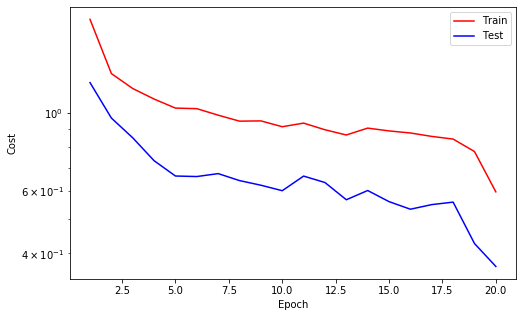

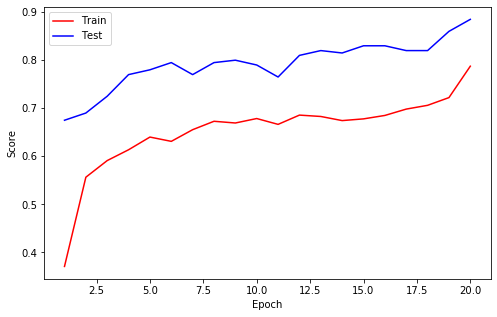



Epoch    21
Train_cost  = 0.5344 | Test_cost  = 0.3438 | Train_score = 0.8196 | Test_score = 0.8900 |




Epoch    22
Train_cost  = 0.4934 | Test_cost  = 0.3273 | Train_score = 0.8282 | Test_score = 0.9000 |




Epoch    23
Train_cost  = 0.4213 | Test_cost  = 0.2872 | Train_score = 0.8532 | Test_score = 0.9050 |




Epoch    24
Train_cost  = 0.3780 | Test_cost  = 0.2862 | Train_score = 0.8782 | Test_score = 0.9150 |




Epoch    25
Train_cost  = 0.3586 | Test_cost  = 0.2747 | Train_score = 0.8754 | Test_score = 0.9050 |
==> EarlyStop patience =  1 | Best test_score: 0.9150




Epoch    26
Train_cost  = 0.3222 | Test_cost  = 0.2806 | Train_score = 0.8879 | Test_score = 0.9050 |
==> EarlyStop patience =  2 | Best test_score: 0.9150




Epoch    27
Train_cost  = 0.2906 | Test_cost  = 0.2754 | Train_score = 0.9014 | Test_score = 0.8900 |
==> EarlyStop patience =  3 | Best test_score: 0.9150
==> Execute Early Stopping at epoch: 27 | Best test_score: 0.9150
==> Best model is saved at model


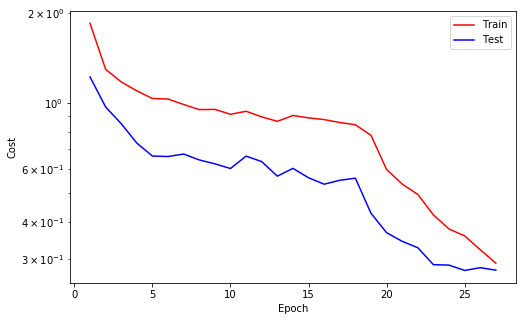

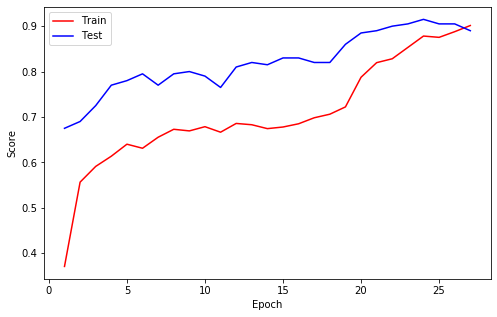

In [22]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [25]:
m = torch.jit.script(Customresnet(config.output_size).to(device))
torch.jit.save(m, 'scripttest.pt')
m.save("scripttest.pt")

In [29]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model, example)
traced_script_module.save("traced_resnet_model.pt")

# Confusion Metrics

In [34]:
from sklearn.metrics import classification_report,confusion_matrix

report = classification_report(target,preds)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.57      1.00      0.73         4
           4       1.00      0.86      0.92         7
           5       1.00      0.80      0.89        10
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         6
           8       0.83      0.83      0.83         6
           9       1.00      1.00      1.00         8

    accuracy                           0.92        64
   macro avg       0.93      0.93      0.92        64
weighted avg       0.94      0.92      0.93        64



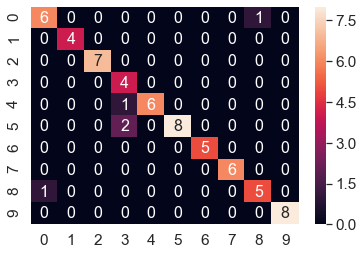

In [36]:
import pandas as pd
import seaborn as sns

confusion = confusion_matrix(target,preds)
df_cm = pd.DataFrame(confusion,range(10),range(10))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()